--- Running Cross-Validation ---

Cross-Validation MAE:
   train-mae-mean  train-mae-std  test-mae-mean  test-mae-std
0        0.252168       0.003055       0.252307      0.012327
--- Finished Cross-Validation ---

MAE of Reconstructed XGBoost Model: 0.27
MSE of Reconstructed XGBoost Model: 2.60
R2 Score of Reconstructed XGBoost Model: 0.98

MAE of Persistence Baseline (Original Values): 0.27
MSE of Persistence Baseline (Original Values): 2.68
R2 Score of Persistence Baseline (Original Values): 0.98

The persistence baseline performs better or equal to the Reconstructed XGBoost model.

Cross-Validation MAE:
   train-mae-mean  train-mae-std  test-mae-mean  test-mae-std
0        0.252168       0.003055       0.252307      0.012327
--- Finished Cross-Validation ---

MAE of Reconstructed XGBoost Model: 0.27
MSE of Reconstructed XGBoost Model: 2.60
R2 Score of Reconstructed XGBoost Model: 0.98

MAE of Persistence Baseline (Original Values): 0.27
MSE of Persistence Baseline (Original Values)

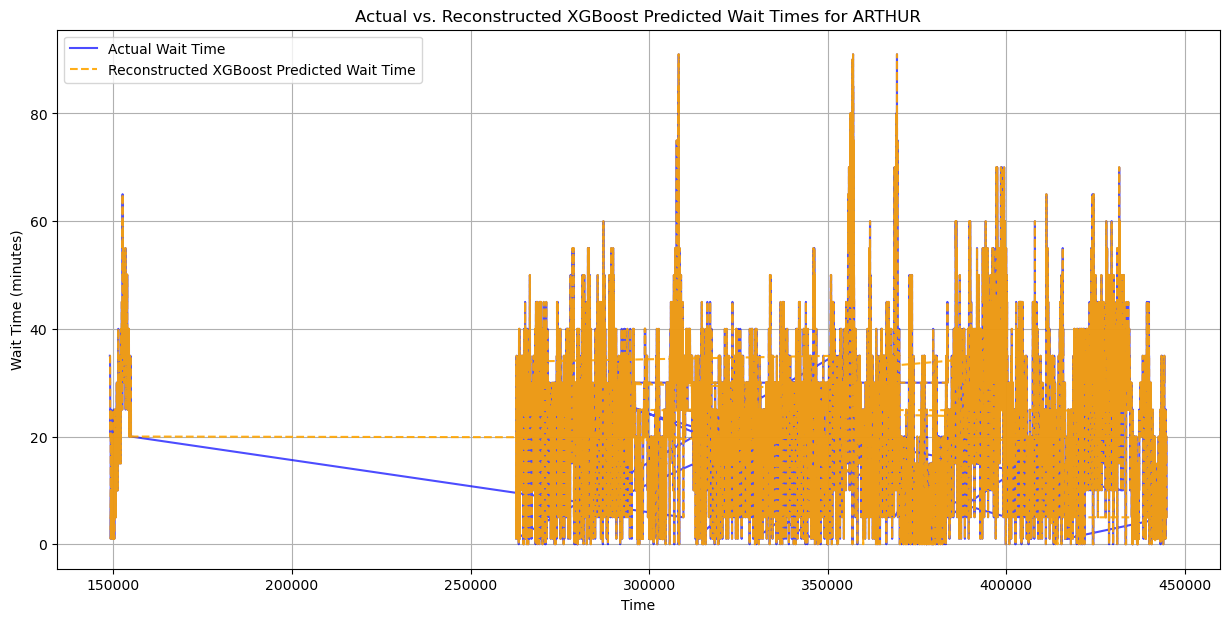

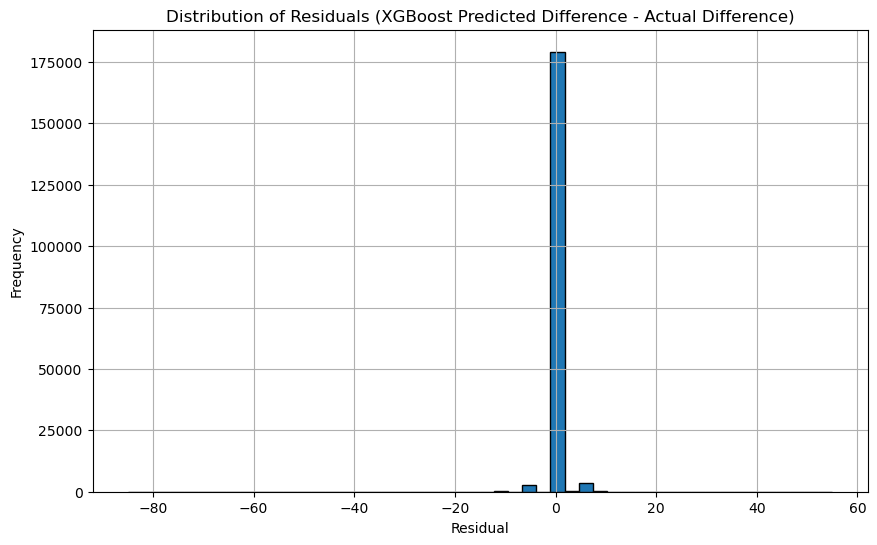


Python script using XGBoost has been executed successfully.


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb

# Load the correct dataset
df = pd.read_csv('park_open_hours.csv')

# --- Phase 1: Data Preparation and Feature Engineering ---

# Create DateTime column from 'Date' and 'Time' columns
df.dropna(subset=['Date', 'Time'], inplace=True)
df['DateTime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])

# Initial Preprocessing
df = df.sort_values('DateTime')

# Handle any remaining special wait time codes
df['ARTHUR_WaitTime_Clean'] = df['ARTHUR_WaitTime'].copy()
df.loc[df['ARTHUR_WaitTime_Clean'] <= 0, 'ARTHUR_WaitTime_Clean'] = 0

# Generate Original Lag1 (for Reconstruction)
df['ARTHUR_WaitTime_lag1_original'] = df['ARTHUR_WaitTime_Clean'].shift(1)

# Calculate Differenced Series
df['ARTHUR_WaitTime_diff'] = df['ARTHUR_WaitTime_Clean'].diff()

# Handle NaNs from Differencing/Lagging
df = df.dropna(subset=['ARTHUR_WaitTime_diff', 'ARTHUR_WaitTime_lag1_original'])

# Generate Lag Features for Differenced Series
for i in range(1, 3):
    df[f'ARTHUR_WaitTime_diff_lag{i}'] = df['ARTHUR_WaitTime_diff'].shift(i)

# Handle NaNs from lag feature creation
df = df.dropna()

# Extract Time-Based Features
df['hour_of_day'] = df['DateTime'].dt.hour
df['day_of_week'] = df['DateTime'].dt.dayofweek
df['day_of_year'] = df['DateTime'].dt.dayofyear
df['month'] = df['DateTime'].dt.month
df['is_weekend'] = (df['DateTime'].dt.dayofweek >= 5).astype(int)
df['minute_of_hour'] = df['DateTime'].dt.minute

# Define Features (X) and Labels (y)
features = [
    'ARTHUR_WaitTime_diff_lag1', 'ARTHUR_WaitTime_diff_lag2',
    'hour_of_day', 'day_of_week', 'day_of_year', 'month', 'is_weekend', 'minute_of_hour'
]
X = df[features]
y = df['ARTHUR_WaitTime_diff']
y_original = df['ARTHUR_WaitTime_Clean']
lagged_original_wait_time = df['ARTHUR_WaitTime_lag1_original']

# --- Phase 2: Model Training and Prediction ---

# Data Splitting
X_train, X_test, y_train, y_test, y_original_train, y_original_test, lagged_original_train, lagged_original_test = train_test_split(
    X, y, y_original, lagged_original_wait_time, test_size=0.5, shuffle=False
)

# --- Phase 2a: Cross-validation ---
print("--- Running Cross-Validation ---")
# Create DMatrix for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)

# Cross-validation parameters
params = {
    'objective': 'reg:squarederror',
    'learning_rate': 0.05,
    'random_state': 42
}

# Perform cross-validation
cv_results = xgb.cv(
    dtrain=dtrain,
    params=params,
    nfold=5,  # 5-fold cross-validation
    num_boost_round=1000,
    early_stopping_rounds=50, # Stop if performance doesn't improve for 50 rounds
    metrics='mae',
    as_pandas=True,
    seed=42
)

print("\nCross-Validation MAE:")
print(cv_results.tail(1))
print("--- Finished Cross-Validation ---\n")


# Model Initialization with XGBoost
# Use the optimal number of boosting rounds from CV
n_estimators = len(cv_results)
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=n_estimators, learning_rate=0.05, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Prediction of Differences
y_pred_diff = model.predict(X_test)

# --- Phase 3: Reconstruction and Evaluation ---

# Reconstruction of Total Wait Times
y_pred_reconstructed = lagged_original_test.values + y_pred_diff

# Ensure non-negative predictions
y_pred_reconstructed[y_pred_reconstructed < 0] = 0

# Model Performance Metrics
mae_reconstructed = mean_absolute_error(y_original_test, y_pred_reconstructed)
mse_reconstructed = mean_squared_error(y_original_test, y_pred_reconstructed)
r2_reconstructed = r2_score(y_original_test, y_pred_reconstructed)
print(f'MAE of Reconstructed XGBoost Model: {mae_reconstructed:.2f}')
print(f'MSE of Reconstructed XGBoost Model: {mse_reconstructed:.2f}')
print(f'R2 Score of Reconstructed XGBoost Model: {r2_reconstructed:.2f}')

# Persistence Baseline (Original Values)
persistence_pred = lagged_original_test
mae_persistence = mean_absolute_error(y_original_test, persistence_pred)
mse_persistence = mean_squared_error(y_original_test, persistence_pred)
r2_persistence = r2_score(y_original_test, persistence_pred)
print(f'\nMAE of Persistence Baseline (Original Values): {mae_persistence:.2f}')
print(f'MSE of Persistence Baseline (Original Values): {mse_persistence:.2f}')
print(f'R2 Score of Persistence Baseline (Original Values): {r2_persistence:.2f}')

# Comparison and Interpretation
if mae_reconstructed < mae_persistence:
    print("\nThe Reconstructed XGBoost model performs better than the persistence baseline.")
else:
    print("\nThe persistence baseline performs better or equal to the Reconstructed XGBoost model.")

# --- Visualizations ---

# Plot Actual vs. Reconstructed Predicted Wait Times
plt.figure(figsize=(15, 7))
plt.plot(y_original_test.index, y_original_test, label='Actual Wait Time', color='blue', alpha=0.7)
plt.plot(y_original_test.index, y_pred_reconstructed, label='Reconstructed XGBoost Predicted Wait Time', color='orange', linestyle='--', alpha=0.9)
plt.title('Actual vs. Reconstructed XGBoost Predicted Wait Times for ARTHUR')
plt.xlabel('Time')
plt.ylabel('Wait Time (minutes)')
plt.legend()
plt.grid(True)
plt.show()

# Plot Distribution of Residuals
residuals = y_test - y_pred_diff
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=50, edgecolor='black')
plt.title('Distribution of Residuals (XGBoost Predicted Difference - Actual Difference)')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

print("\nPython script using XGBoost has been executed successfully.")

